In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as s_int
import time
import pyro.mesh.boundary as bnd
import pyro.mesh.patch as patch
from pyro import Pyro

In [3]:
#use scipy kdtree package
from scipy.spatial import KDTree

#generate uniform random positions in 3D for N equal mass particles
def gen_positions(N, seed=1214):
    #set seed
    np.random.seed(seed)
    #random unifrom positions
    return np.random.uniform(0, 100, size=(N, 3))

Text(0.5, 0.92, 'Random Positions of 1000 Particles in 3D')

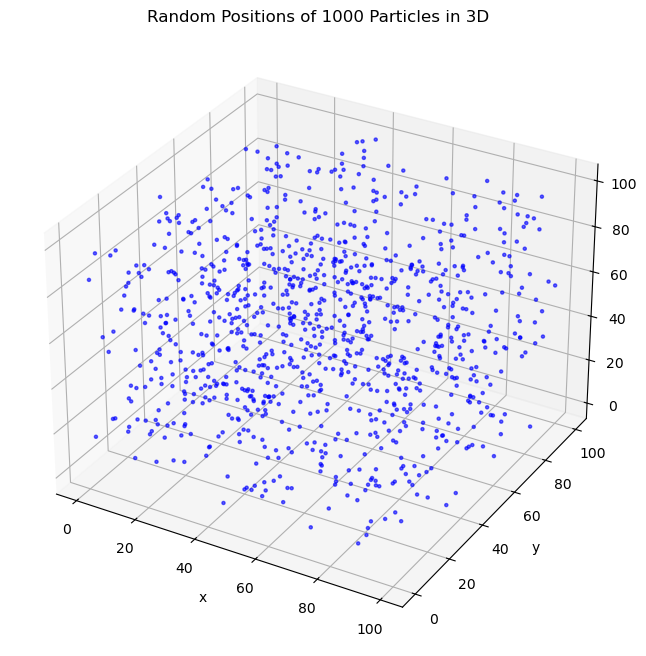

In [5]:
#check position generation via plotting
N = 1000
positions = gen_positions(N)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], color='blue', s=5, alpha=0.6)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z', labelpad=10) #for some reason the z label won't show up no matter what...
ax.set_title(f'Random Positions of 1000 Particles in 3D')


In [7]:
#direct method of calculating acceleration of every particle
def direct_acceleration(positions):
    #set grav constant to 1.0 for now as no units in problem
    G=1.0
    #number of particles
    N=positions.shape[0]
    #initialize acceleration arr
    net_acceleration=np.zeros_like(positions)
    #dtermine acceleration
    for i in range(N):
        #position difference to the other paricles
        place=positions-positions[i]
        #magnitude of distance to other particles
        mag=np.linalg.norm(place, axis=1)
        #mask including all other particles, so can make sure no self interaction
        mask=np.arange(N)!=i
        #gravitational acceleration from every other particle
        acceleration=G*place[mask]/mag[mask][:, None]**3
        #sum accerlerations to get net acc
        net_acceleration[i]=np.sum(acceleration, axis=0)
    return net_acceleration

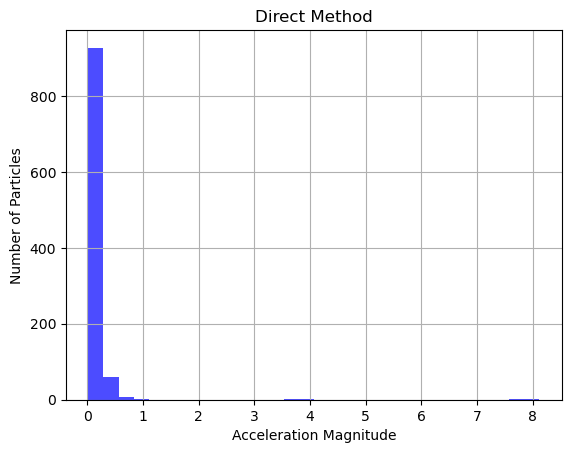

In [9]:
#check direct method via plotting
N = 1000
positions = gen_positions(N)
accelerations=direct_acceleration(positions)

#get magnitude of accelerations
mag_accelerations=np.linalg.norm(accelerations, axis=1)

plt.hist(mag_accelerations, bins=30, alpha=0.7, color='blue')
plt.xlabel("Acceleration Magnitude")
plt.ylabel("Number of Particles")
plt.title("Direct Method")
plt.grid(True)
plt.show()

In [11]:
#start kdtree method of calculating acceleration of every particle
#couldn't figure out how to use scipy kdtree so will write an octree

#octree node class for organization
class OctreeNode:
    #node
    def __init__(self, center, size, indices):
        #center of node
        self.center=center
        #length of cube
        self.size=size
        #indices of particles
        self.indices = indices
        #children
        self.children=[]
        #total node mass
        self.mass=0
        #com
        self.com=np.zeros(3)

    #check if node has children
    def is_leaf(self):
        return len(self.children)==0

#build octree (basically 3D quadtree from how I understand it)
def octree(positions, indices, center, size, max_leaf_size=5): #set it so each particle gets a node for now
    node=OctreeNode(center, size, indices)
    #compute mass and com if sufficiently small number of particles
    if len(indices)<=max_leaf_size:
        node.mass=len(indices)
        node.com=positions[indices].mean(axis=0)
        return node

    #if too many, divide further into octants
    #offset where the centers of new cubes are 
    move_cen=np.array([[dx, dy, dz] for dx in [-0.5,0.5] for dy in [-0.5,0.5] for dz in [-0.5,0.5]])
    #reduce size by half
    child_size=size/2

    #see which particles go in sub nodes
    for move in move_cen:
        new_cen=center+move*child_size
        within_child=[idx for idx in indices if np.all(np.abs(positions[idx]-new_cen)<=child_size/2)]
        if within_child:
            #child node
            child_node=octree(positions, within_child, new_cen, child_size, max_leaf_size)
            node.children.append(child_node)

    #compute total mass and com of children
    if node.children:
        total_mass=sum(child.mass for child in node.children)
        com=sum(child.mass*child.com for child in node.children)/total_mass
        node.mass=total_mass
        node.com=com

    return node
    

In [13]:
#kdtree method of calculating acceleration of every particle cont.
#https://arborjs.org/docs/barnes-hut, this was very helpful for understanding Barnes-Hut and force calculation
#force calculation
def kdtree_force(node, pos_i, theta=0.5): #used recommended theta from source above
    G=1.0
    #force if node has children
    if node.is_leaf():
    #don't include self    
        if len(node.indices) == 1 and np.allclose(pos_i, node.com):
            return np.zeros(3)
        r_vector=node.com-pos_i
        r_mag=np.linalg.norm(r_vector)
        return G*node.mass*r_vector/r_mag**3

    #distance from particle to node com if not a leaf
    r_vector=node.com-pos_i
    r_mag=np.linalg.norm(r_vector)

    #Barnes-Hut grouping
    if node.size/r_mag<theta:
        return G*node.mass*r_vector/r_mag**3
    #else go to children
    else:
        force=np.zeros(3)
        for child in node.children:
            #adding forces
            force+=kdtree_force(child, pos_i)
        return force

#acceleration calculation
def kdtree_acceleration(positions):
    #number of particles
    N=positions.shape[0]
    #center of cube
    root_center=np.array([50, 50, 50])
    root_size=100
    indices=list(range(N))

    #make octree
    root=octree(positions, indices, root_center, root_size)

    #accleration calc
    accelerations=np.zeros_like(positions)
    for i in range(N):
        accelerations[i]=kdtree_force(root, positions[i])

    return accelerations
    

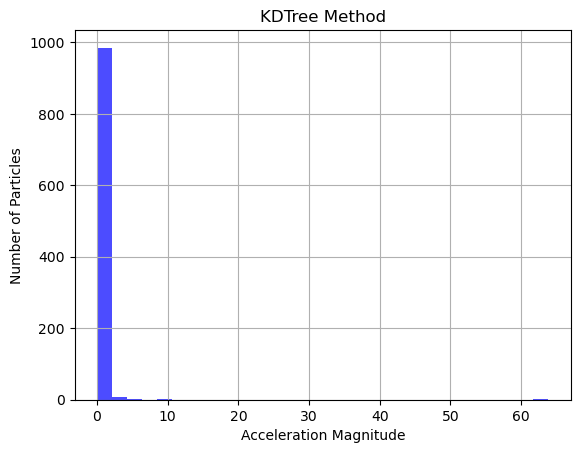

In [15]:
#check kdtree method via plotting
N = 1000
positions = gen_positions(N)
accelerations=kdtree_acceleration(positions)

#get magnitude of accelerations
mag_accelerations=np.linalg.norm(accelerations, axis=1)

plt.hist(mag_accelerations, bins=30, alpha=0.7, color='blue')
plt.xlabel("Acceleration Magnitude")
plt.ylabel("Number of Particles")
plt.title("KDTree Method")
plt.grid(True)
plt.show()

In [33]:
#now to answer the question
#different numbers of particles
N=[1000, 10**4, 10**5, 10**6]

#initialize lists to store times
direct_times=[]
kdtree_times=[]

#after trial and error I know that direct 10**6 takes an infeasible amount of time so I will skip the calculation
            
#find times for different N by method
for N_i in N:
    positions=gen_positions(N_i)

    #direct times
    if N_i > 10**5:
        direct_prog = None
    else:
        print(f"Running direct method for N = {N_i}")
        start = time.time()
        acc = direct_acceleration(positions)
        direct_prog = time.time() - start

    #kdtree times
    print(f"Running KDTree method for N = {N_i}")
    start = time.time()
    acc = kdtree_acceleration(positions)
    kdtree_prog = time.time() - start

    direct_times.append(direct_prog)
    kdtree_times.append(kdtree_prog)

    direct_str = f"{direct_prog:.4f}" if direct_prog is not None else "infeasible"
    kdtree_str = f"{kdtree_prog:.4f}" if kdtree_prog is not None else "infeasible"
    print(f"N={N_i} | Direct Time (s)={direct_str} | KDTree Time (s)={kdtree_str}")
    

Running direct method for N = 1000
Running KDTree method for N = 1000
N=1000 | Direct Time (s)=0.0832 | KDTree Time (s)=1.2370
Running direct method for N = 10000
Running KDTree method for N = 10000
N=10000 | Direct Time (s)=4.4693 | KDTree Time (s)=17.5118
Running direct method for N = 100000
Running KDTree method for N = 100000
N=100000 | Direct Time (s)=442.0501 | KDTree Time (s)=239.6172
Running KDTree method for N = 1000000
N=1000000 | Direct Time (s)=infeasible | KDTree Time (s)=3337.0656


In [46]:
#do this again for up yo 10**5, forgot to store accelerations
#different numbers of particles
N=[1000, 10**4, 10**5]

#initialize lists to store times
direct_times=[]
kdtree_times=[]

direct_accs = []
kdtree_accs = []

#after trial and error I know that direct 10**6 takes an infeasible amount of time so I will skip the calculation
            
#find times for different N by method
for N_i in N:
    positions=gen_positions(N_i)

    #direct times
    if N_i > 10**5:
        direct_prog = None
        direct_accs.append(None)
    else:
        print(f"Running direct method for N = {N_i}")
        start = time.time()
        acc = direct_acceleration(positions)
        direct_prog = time.time() - start
        direct_accs.append(acc)

    #kdtree times
    print(f"Running KDTree method for N = {N_i}")
    start = time.time()
    acc = kdtree_acceleration(positions)
    kdtree_prog = time.time() - start
    kdtree_accs.append(acc)
    
    direct_times.append(direct_prog)
    kdtree_times.append(kdtree_prog)

    direct_str = f"{direct_prog:.4f}" if direct_prog is not None else "infeasible"
    kdtree_str = f"{kdtree_prog:.4f}" if kdtree_prog is not None else "infeasible"
    print(f"N={N_i} | Direct Time (s)={direct_str} | KDTree Time (s)={kdtree_str}")

Running direct method for N = 1000
Running KDTree method for N = 1000
N=1000 | Direct Time (s)=0.0734 | KDTree Time (s)=1.2571
Running direct method for N = 10000
Running KDTree method for N = 10000
N=10000 | Direct Time (s)=3.9531 | KDTree Time (s)=18.5444
Running direct method for N = 100000
Running KDTree method for N = 100000
N=100000 | Direct Time (s)=455.5375 | KDTree Time (s)=244.8570


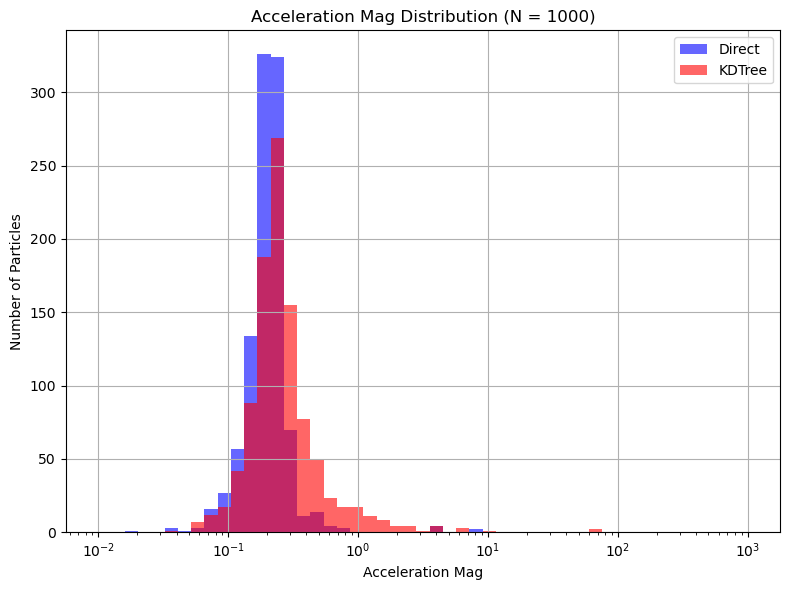

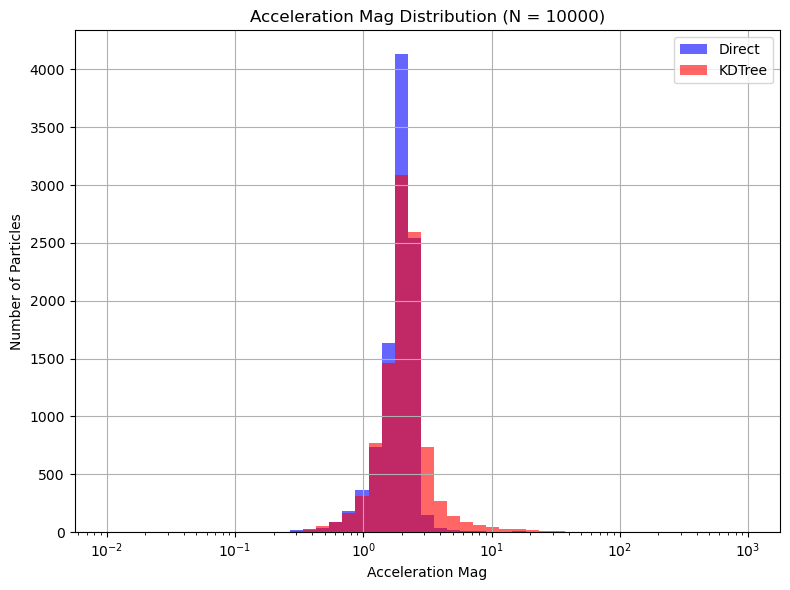

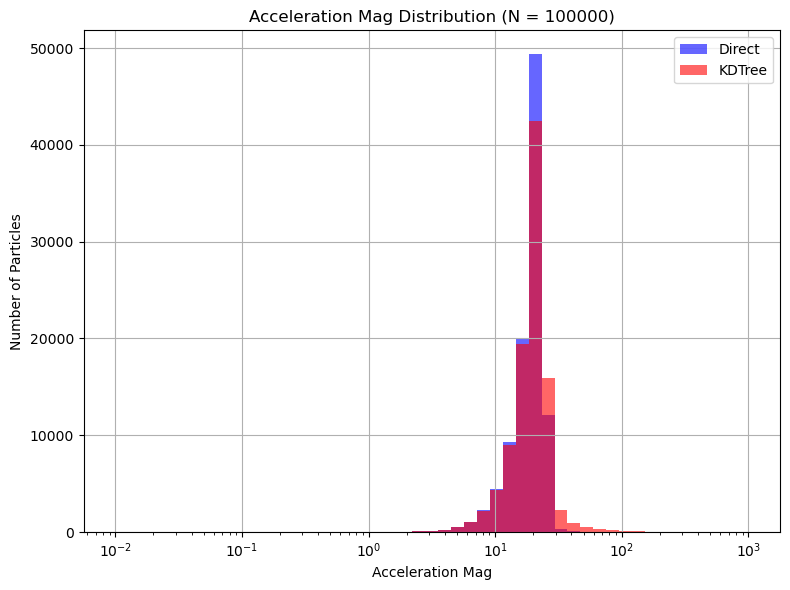

In [56]:
#plot accelerations for different N and method
N = [1000, 10**4, 10**5]

for i, N_i in enumerate(N):
    acc_direct = direct_accs[i]
    acc_kdtree = kdtree_accs[i]

    #calc magnitudes
    mag_direct = np.linalg.norm(acc_direct, axis=1) if acc_direct is not None else None
    mag_kdtree = np.linalg.norm(acc_kdtree, axis=1)

    #plot
    plt.figure(figsize=(8, 6))
    plt.xscale('log')
    plt.hist(mag_direct, color='blue', bins=np.logspace(-2, 3, 50), alpha=0.6, label="Direct")
    plt.hist(mag_kdtree, color='red', bins=np.logspace(-2, 3, 50), alpha=0.6, label="KDTree")
    plt.title(f"Acceleration Mag Distribution (N = {N_i})")
    plt.xlabel("Acceleration Mag")
    plt.ylabel("Number of Particles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Question Answers:
-

My reasoning for octree over kdtree:
I chose to use an octree instead of a kdtree as we aimed to copmute acceleration for N particles, which is more suited to volume grouping (in my opinion, but not super sure). I also thought it would be interesting to look at summing over all particles rather than only using nearest neighbors to sum acceleration, so I ended up going with an octree, I hope that is ok.

Problem 1 questions:

For the direct method the time scales approximately with N squared, while for the octree method it sclaes slower than the direct method, but a bit faster than scaling with N (some form of N times another factor).

Yes, the results differ by method, however this change is seen in the details of the overall distributions as KDTRree method introduces small errors, but both methods appear toagree on peak values so KDTree (in my case octree) seems to be a good method.

In [132]:
!find . -name "pyro_sim.py"

./pyro_sim.py


In [111]:
!ls pyro_sim.py

pyro_sim.py


In [180]:
#KH as in code guide
vbulk = 0.0
!python pyro_sim.py compressible kh inputs.kh

pyro ...
{}
warning, key: vis.plot_file not defined
initializing the Kelvin-Helmholtz problem...
cc data: nx = 64, ny = 64, ng = 4
         nvars = 4
         variables:
         density: min:    1.0000310272    max:    1.9999689728
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
          energy: min:    6.2622980773    max:    6.5000641336
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      x-momentum: min:   -0.4999844855    max:    0.9999224330
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      y-momentum: min:   -0.0199033858    max:    0.0199033858
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    

Figure(800x600)
    1    0.00005    0.00005
Figure(640x480)
    2    0.00016    0.00011
Figure(640x480)
    3    0.00037    0.00021
Figure(640x480)
    4    0.00079    0.00042
Figure(640x480)
    5    0.00163    0

In [182]:
!ls

__init__.py            kh_0074.h5             kh_0393.h5
__pycache__            kh_0082.h5             kh_0415.h5
_defaults              kh_0101.h5             kh_0450.h5
_version.py            kh_0108.h5             kh_0484.h5
advection              kh_0120.h5             kh_0519.h5
advection_fv4          kh_0139.h5             kh_0554.h5
advection_nonuniform   kh_0142.h5             kh_0555.h5
advection_rk           kh_0158.h5             kh_0590.h5
advection_weno         kh_0176.h5             kh_0626.h5
analysis               kh_0177.h5             kh_0662.h5
burgers                kh_0196.h5             kh_0698.h5
burgers_viscous        kh_0210.h5             lm_atm
compressible           kh_0215.h5             mesh
compressible_fv4       kh_0235.h5             multigrid
compressible_react     kh_0244.h5             particles
compressible_rk        kh_0254.h5             plot.py
compressible_sdc       kh_0273.h5             pyro_sim.py
diffusion              kh_0278.h5            

In [184]:
!find . -name "inputs.kh"

./swe/problems/inputs.kh
./compressible/problems/inputs.kh


In [186]:
import h5py

filename = "kh_0063.h5"

with h5py.File(filename, "r") as f:
    print("Top-level keys:")
    print(list(f.keys()))

import h5py

filename = "kh_0063.h5"

with h5py.File(filename, "r") as f:
    print("Keys inside state/density:")
    print(list(f["state"]["density"].keys()))

Top-level keys:
['BC', 'aux', 'grid', 'runtime parameters', 'state']
Keys inside state/density:
['data']


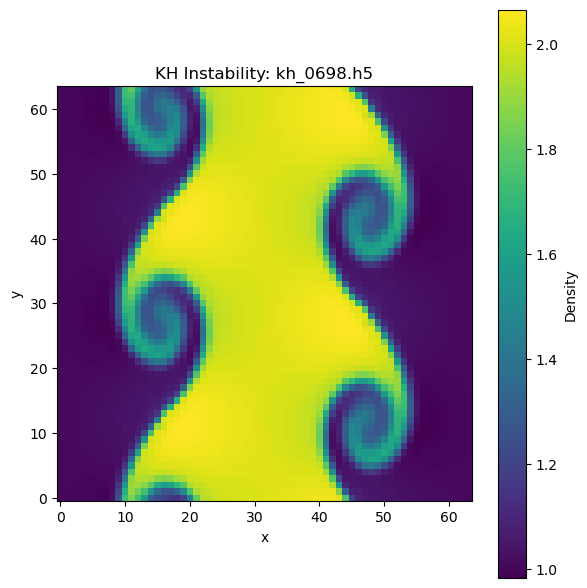

In [188]:
import h5py

#plot
filename = "kh_0698.h5"  
with h5py.File(filename, "r") as f:
    density = f["state"]["density"]["data"][:]

plt.figure(figsize=(6, 6))
plt.imshow(density, origin="lower", cmap="viridis")
plt.colorbar(label="Density")
plt.title(f"KH Instability: {filename}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

In [190]:
#now do for compressible_rk
!python pyro_sim.py compressible_rk kh inputs.kh 

pyro ...
{}
warning, key: vis.plot_file not defined
initializing the Kelvin-Helmholtz problem...
cc data: nx = 64, ny = 64, ng = 4
         nvars = 4
         variables:
         density: min:    1.0000310272    max:    1.9999689728
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
          energy: min:    6.2622980773    max:    6.5000641336
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      x-momentum: min:   -0.4999844855    max:    0.9999224330
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      y-momentum: min:   -0.0199033858    max:    0.0199033858
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    

Figure(800x600)
    1    0.00003    0.00003
Figure(640x480)
    2    0.00009    0.00006
Figure(640x480)
    3    0.00021    0.00012
Figure(640x480)
    4    0.00044    0.00024
Figure(640x480)
    5    0.00091    0

In [192]:
!ls

__init__.py            kh_0074.h5             kh_0393.h5
__pycache__            kh_0082.h5             kh_0415.h5
_defaults              kh_0101.h5             kh_0450.h5
_version.py            kh_0108.h5             kh_0484.h5
advection              kh_0120.h5             kh_0519.h5
advection_fv4          kh_0139.h5             kh_0554.h5
advection_nonuniform   kh_0142.h5             kh_0555.h5
advection_rk           kh_0158.h5             kh_0590.h5
advection_weno         kh_0176.h5             kh_0626.h5
analysis               kh_0177.h5             kh_0662.h5
burgers                kh_0196.h5             kh_0698.h5
burgers_viscous        kh_0210.h5             lm_atm
compressible           kh_0215.h5             mesh
compressible_fv4       kh_0235.h5             multigrid
compressible_react     kh_0244.h5             particles
compressible_rk        kh_0254.h5             plot.py
compressible_sdc       kh_0273.h5             pyro_sim.py
diffusion              kh_0278.h5            

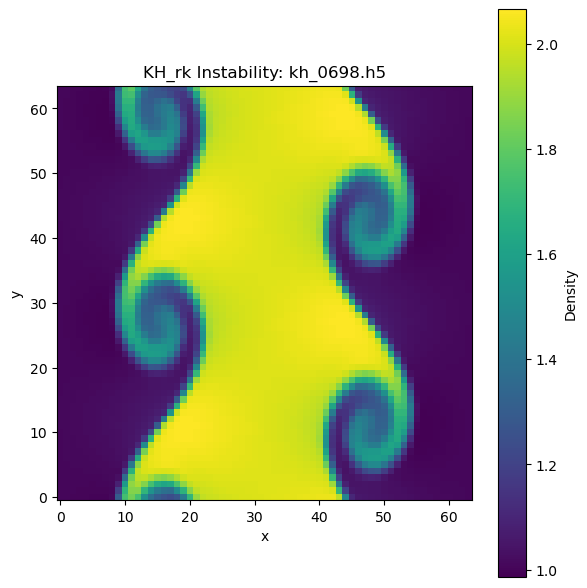

In [194]:
#plot
filename = "kh_0698.h5"  
with h5py.File(filename, "r") as f:
    density = f["state"]["density"]["data"][:]

plt.figure(figsize=(6, 6))
plt.imshow(density, origin="lower", cmap="viridis")
plt.colorbar(label="Density")
plt.title(f"KH_rk Instability: {filename}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

In [196]:
#now do for compressible_fv4
!python pyro_sim.py compressible_fv4 kh inputs.kh

pyro ...
{}
warning, key: vis.plot_file not defined
initializing the Kelvin-Helmholtz problem...
cc data: nx = 64, ny = 64, ng = 4
         nvars = 4
         variables:
         density: min:    1.0000310272    max:    1.9999689728
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
          energy: min:    6.2622980773    max:    6.5000641336
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      x-momentum: min:   -0.4999844855    max:    0.9999224330
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      y-momentum: min:   -0.0199033858    max:    0.0199033858
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    

Figure(800x600)
    1    0.00003    0.00003
Figure(640x480)
    2    0.00009    0.00006
Figure(640x480)
    3    0.00021    0.00012
Figure(640x480)
    4    0.00044    0.00024
Figure(640x480)
    5    0.00091    0

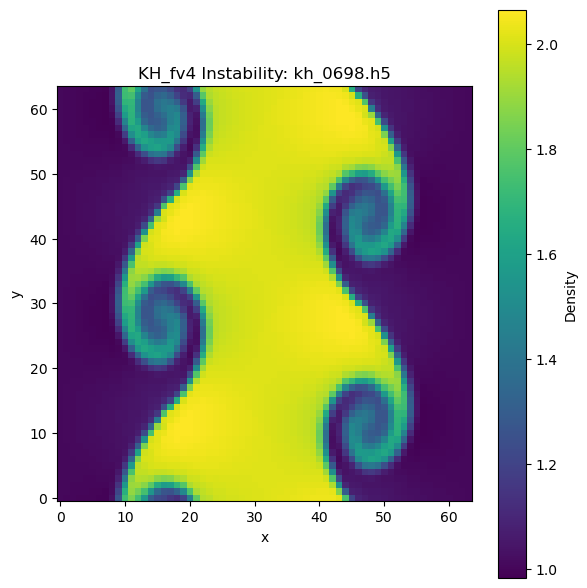

In [198]:
#plot
filename = "kh_0698.h5"  
with h5py.File(filename, "r") as f:
    density = f["state"]["density"]["data"][:]

plt.figure(figsize=(6, 6))
plt.imshow(density, origin="lower", cmap="viridis")
plt.colorbar(label="Density")
plt.title(f"KH_fv4 Instability: {filename}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

In [200]:
#now do for compressible_sdc
!python pyro_sim.py compressible_sdc kh inputs.kh 

pyro ...
{}
warning, key: compressible.limiter not defined
warning, key: vis.plot_file not defined
initializing the Kelvin-Helmholtz problem...
cc data: nx = 64, ny = 64, ng = 4
         nvars = 4
         variables:
         density: min:    1.0000310272    max:    1.9999689728
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
          energy: min:    6.2622980773    max:    6.5000641336
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      x-momentum: min:   -0.4999844855    max:    0.9999224330
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      y-momentum: min:   -0.0199033858    max:    0.0199033858
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    

Figure(800x600)
    1    0.00003    0.00003
Figure(640x480)
    2    0.00009    0.00006
Figure(640x480)
    3    0.00021    0.00012
Figure(640x480)
    4    0.00044  

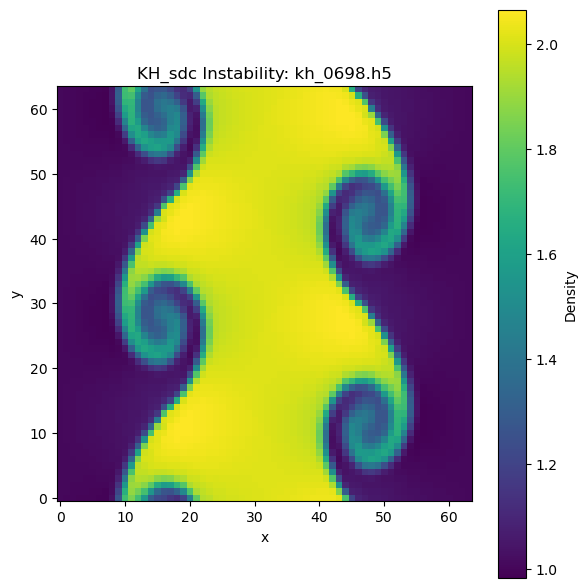

In [202]:
#plot
filename = "kh_0698.h5"  
with h5py.File(filename, "r") as f:
    density = f["state"]["density"]["data"][:]

plt.figure(figsize=(6, 6))
plt.imshow(density, origin="lower", cmap="viridis")
plt.colorbar(label="Density")
plt.title(f"KH_sdc Instability: {filename}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

In [206]:
#now to look at this agin with relative velocity +-10 instead of +-1
!python pyro_sim.py compressible kh inputs.kh kh.u_1=10.0 kh.u_2=-10.0

pyro ...
{'kh.u_1': 10.0, 'kh.u_2': -10.0}
warning, key: vis.plot_file not defined
initializing the Kelvin-Helmholtz problem...
cc data: nx = 64, ny = 64, ng = 4
         nvars = 4
         variables:
         density: min:    1.0000310272    max:    1.9999689728
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
          energy: min:   11.1689691520    max:  106.2361373874
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      x-momentum: min:  -19.9984486606    max:    9.9996897090
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      y-momentum: min:   -0.0199033858    max:    0.0199033858
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    

Figure(800x600)
    1    0.00001    0.00001
Figure(640x480)
    2    0.00003    0.00002
Figure(640x480)
    3    0.00007    0.00004
Figure(640x480)
    4    0.00016    0.00008
Figure

In [208]:
!ls

__init__.py            kh_0142.h5             kh_0626.h5
__pycache__            kh_0158.h5             kh_0662.h5
_defaults              kh_0176.h5             kh_0671.h5
_version.py            kh_0177.h5             kh_0698.h5
advection              kh_0196.h5             kh_0766.h5
advection_fv4          kh_0210.h5             kh_0861.h5
advection_nonuniform   kh_0215.h5             kh_0956.h5
advection_rk           kh_0235.h5             kh_1051.h5
advection_weno         kh_0244.h5             kh_1146.h5
analysis               kh_0254.h5             kh_1241.h5
burgers                kh_0273.h5             kh_1336.h5
burgers_viscous        kh_0278.h5             kh_1431.h5
compressible           kh_0291.h5             kh_1526.h5
compressible_fv4       kh_0293.h5             kh_1621.h5
compressible_react     kh_0312.h5             kh_1716.h5
compressible_rk        kh_0313.h5             kh_1811.h5
compressible_sdc       kh_0333.h5             kh_1906.h5
diffusion              kh_0347.

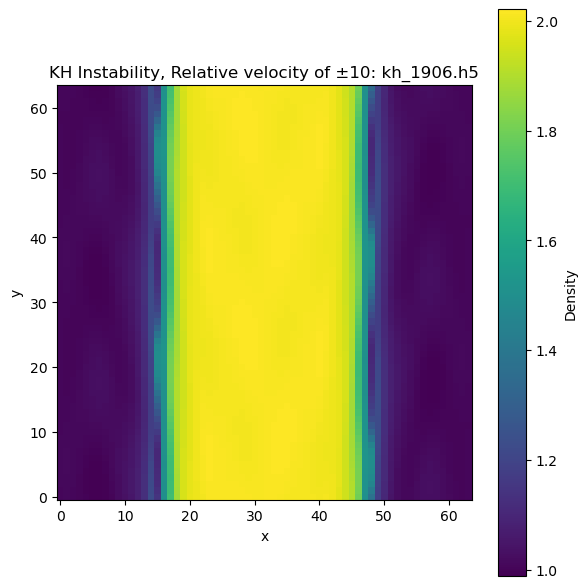

In [210]:
#plot
filename = "kh_1906.h5"  
with h5py.File(filename, "r") as f:
    density = f["state"]["density"]["data"][:]

plt.figure(figsize=(6, 6))
plt.imshow(density, origin="lower", cmap="viridis")
plt.colorbar(label="Density")
plt.title(f"KH Instability, Relative velocity of ±10: {filename}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

In [212]:
#now for compressible_rk
!python pyro_sim.py compressible_rk kh inputs.kh kh.u_1=10.0 kh.u_2=-10.0

pyro ...
{'kh.u_1': 10.0, 'kh.u_2': -10.0}
warning, key: vis.plot_file not defined
initializing the Kelvin-Helmholtz problem...
cc data: nx = 64, ny = 64, ng = 4
         nvars = 4
         variables:
         density: min:    1.0000310272    max:    1.9999689728
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
          energy: min:   11.1689691520    max:  106.2361373874
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      x-momentum: min:  -19.9984486606    max:    9.9996897090
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      y-momentum: min:   -0.0199033858    max:    0.0199033858
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    

Figure(800x600)
    1    0.00001    0.00001
Figure(640x480)
    2    0.00003    0.00002
Figure(640x480)
    3    0.00006    0.00004
Figure(640x480)
    4    0.00014    0.00007
Figure

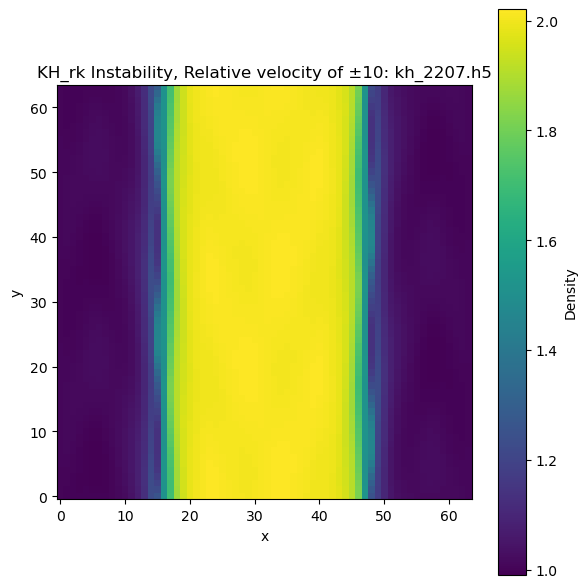

In [216]:
#plot
filename = "kh_2207.h5"  
with h5py.File(filename, "r") as f:
    density = f["state"]["density"]["data"][:]

plt.figure(figsize=(6, 6))
plt.imshow(density, origin="lower", cmap="viridis")
plt.colorbar(label="Density")
plt.title(f"KH_rk Instability, Relative velocity of ±10: {filename}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

In [218]:
#now for compressible_fv4
!python pyro_sim.py compressible_fv4 kh inputs.kh kh.u_1=10.0 kh.u_2=-10.0

pyro ...
{'kh.u_1': 10.0, 'kh.u_2': -10.0}
warning, key: vis.plot_file not defined
initializing the Kelvin-Helmholtz problem...
cc data: nx = 64, ny = 64, ng = 4
         nvars = 4
         variables:
         density: min:    1.0000310272    max:    1.9999689728
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
          energy: min:   11.1689691520    max:  106.2361373874
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      x-momentum: min:  -19.9984486606    max:    9.9996897090
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      y-momentum: min:   -0.0199033858    max:    0.0199033858
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    

Figure(800x600)
    1    0.00001    0.00001
Figure(640x480)
    2    0.00003    0.00002
Figure(640x480)
    3    0.00006    0.00004
Figure(640x480)
    4    0.00014    0.00007
Figure

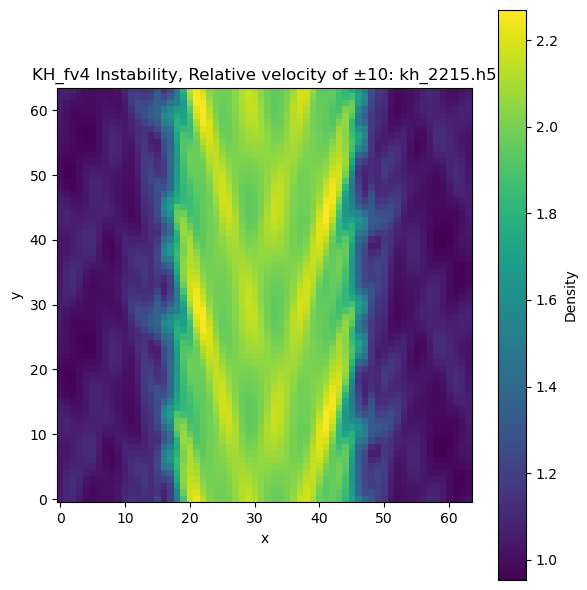

In [220]:
#plot
filename = "kh_2215.h5"  
with h5py.File(filename, "r") as f:
    density = f["state"]["density"]["data"][:]

plt.figure(figsize=(6, 6))
plt.imshow(density, origin="lower", cmap="viridis")
plt.colorbar(label="Density")
plt.title(f"KH_fv4 Instability, Relative velocity of ±10: {filename}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

In [222]:
#now for compressible_sdc
!python pyro_sim.py compressible_sdc kh inputs.kh kh.u_1=10.0 kh.u_2=-10.0

pyro ...
{'kh.u_1': 10.0, 'kh.u_2': -10.0}
warning, key: compressible.limiter not defined
warning, key: vis.plot_file not defined
initializing the Kelvin-Helmholtz problem...
cc data: nx = 64, ny = 64, ng = 4
         nvars = 4
         variables:
         density: min:    1.0000310272    max:    1.9999689728
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
          energy: min:   11.1689691520    max:  106.2361373874
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      x-momentum: min:  -19.9984486606    max:    9.9996897090
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
      y-momentum: min:   -0.0199033858    max:    0.0199033858
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    

Figure(800x600)
    1    0.00001    0.00001
Figure(640x480)
    2    0.00003    0.00002
Figure(640x480)
    3    0.00006    0.00004
Fig

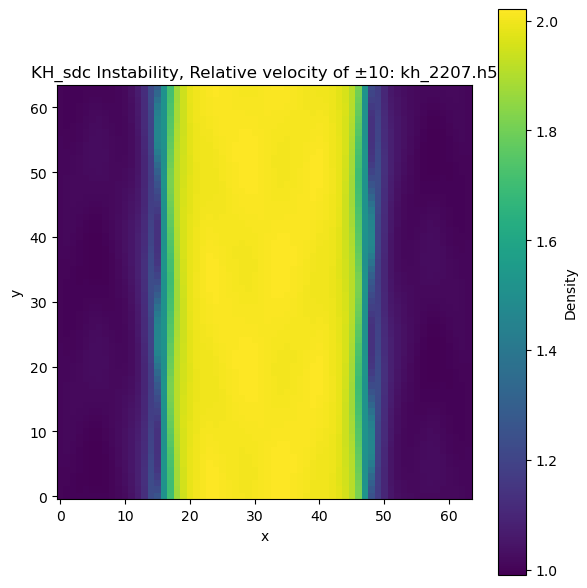

In [224]:
#plot
filename = "kh_2207.h5"  
with h5py.File(filename, "r") as f:
    density = f["state"]["density"]["data"][:]

plt.figure(figsize=(6, 6))
plt.imshow(density, origin="lower", cmap="viridis")
plt.colorbar(label="Density")
plt.title(f"KH_sdc Instability, Relative velocity of ±10: {filename}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

Problem Questions:
-
For the relative velocity of +-10, the fluids look much more mixed/chaotic and noisy. It also took less time for more discrepant velocities to induce mixing so we no longer see the nice rolls. This comes from the increased shear, which increases energy input and mixing intensity. However there may be more fine structure (we get a hint with fv4) in the relative velocity of +-10 that we are missing because of the resolution, I would like to follow up and see if this is the case sometime.